# Glass structure - evolutionary approach

In [1]:
import numpy as np

In [2]:
rng = np.random.default_rng()

## Data preparation and utility functions

In [3]:
from itertools import dropwhile, takewhile
import re

def read_atoms(input_path):
    with open(input_path, 'r') as file:
        lines = file.readlines()
        
        atom_spec_lines = list(takewhile(lambda line: line != 'ATOMIC_POSITIONS (angstrom)\n', dropwhile(lambda line: line != 'ATOMIC_SPECIES\n', lines)))[1:]
        atom_species_by_index = {i: symbol for i, symbol in enumerate([line.split()[0] for line in atom_spec_lines])}
        atom_species_by_symbol = {symbol: i for i, symbol in atom_species_by_index.items()}
        
        atom_pos_lines = list(dropwhile(lambda line: line != 'ATOMIC_POSITIONS (angstrom)\n', lines))[1:-2]
        atom_positions = [(float(x), float(y), float(z), atom_species_by_symbol[symbol]) for symbol, x, y, z in [line.split() for line in atom_pos_lines]]

        cell_size_line = next(line for line in lines if line.startswith('  ibrav'))
        cell_size_match = re.search(r'a=(\d+(\.\d+)?)', cell_size_line)
        cell_size = float(cell_size_match.group(1)) if cell_size_match else None

    return atom_species_by_index, atom_species_by_symbol, np.array(atom_positions), cell_size

In [4]:
def get_solution_size(cluster_size, solution_thickness, axis):
    match axis:
        case 0:
            size_x = solution_thickness
            size_y = cluster_size
            size_z = cluster_size
        case 1:
            size_x = cluster_size + solution_thickness
            size_y = solution_thickness
            size_z = cluster_size
        case 2:
            size_x = cluster_size + solution_thickness
            size_y = cluster_size + solution_thickness
            size_z = solution_thickness

    return size_x, size_y, size_z

In [5]:
def get_atoms_in_cuboid(atoms, min_x, max_x, min_y, max_y, min_z, max_z):
    return atoms[
        (atoms[:, 0] > min_x)
        & (atoms[:, 0] < max_x)
        & (atoms[:, 1] > min_y)
        & (atoms[:, 1] < max_y)
        & (atoms[:, 2] > min_z)
        & (atoms[:, 2] < max_z)
    ]


def cut_atoms(atoms, center, x_size, y_size, z_size):
    x_min, x_max = center[0] - x_size/2, center[0] + x_size/2
    y_min, y_max = center[1] - y_size/2, center[1] + y_size/2
    z_min, z_max = center[2] - z_size/2, center[2] + z_size/2

    center_coords = np.array(np.concat([center[:3], [0]]))

    return get_atoms_in_cuboid(atoms, x_min, x_max, y_min, y_max, z_min, z_max) - center_coords

In [6]:
def get_positioned_walls_x(cluster, cluster_size, wall_thickness, solution_thickness):
    wall_x_left = cluster[cluster[:, 0] < -cluster_size / 2 + wall_thickness]
    wall_x_right = cluster[cluster[:, 0] > cluster_size / 2 - wall_thickness]

    wall_x_left_shifted = wall_x_left + np.array([cluster_size/2 + solution_thickness/2, 0, 0, 0])
    wall_x_right_shifted = wall_x_right - np.array([cluster_size/2 + solution_thickness/2, 0, 0, 0])

    return wall_x_left_shifted, wall_x_right_shifted


def get_positioned_walls_y(solution_x, cluster, cluster_size, wall_thickness, solution_thickness):
    atoms = np.concat([cluster, solution_x])

    wall_y_bottom = atoms[atoms[:, 1] < -cluster_size / 2 + wall_thickness]
    wall_y_top = atoms[atoms[:, 1] > cluster_size / 2 - wall_thickness]

    wall_y_bottom_shifted = wall_y_bottom + np.array([0, cluster_size/2 + solution_thickness/2, 0, 0])
    wall_y_top_shifted = wall_y_top - np.array([0, cluster_size/2 + solution_thickness/2, 0, 0])

    return wall_y_bottom_shifted, wall_y_top_shifted


def get_positioned_walls_z(solution_x, solution_y, cluster, cluster_size, wall_thickness, solution_thickness):
    atoms = np.concat([cluster, solution_x, solution_y])

    wall_z_back = atoms[atoms[:, 2] < -cluster_size / 2 + wall_thickness]
    wall_z_front = atoms[atoms[:, 2] > cluster_size / 2 - wall_thickness]

    wall_z_back_shifted = wall_z_back + np.array([0, 0, cluster_size/2 + solution_thickness/2, 0])
    wall_z_front_shifted = wall_z_front - np.array([0, 0, cluster_size/2 + solution_thickness/2, 0])

    return wall_z_back_shifted, wall_z_front_shifted

In [7]:
def get_random_solution(supercell, cell_size, x_size, y_size, z_size):
    center = rng.uniform(-cell_size/2, cell_size/2, 3)
    return cut_atoms(supercell, center, x_size, y_size, z_size)


def get_random_solution_without_Er(supercell, cell_size, atom_species_by_symbol, x_size, y_size, z_size):
    solution = get_random_solution(supercell, cell_size, x_size, y_size, z_size)
    while np.any(solution[:, 3] == atom_species_by_symbol['Er']):
        solution = get_random_solution(supercell, cell_size, x_size, y_size, z_size)

    return solution


def get_n_random_solutions_without_Er(supercell, cell_size, atom_species_by_symbol, cluster_size, solution_thickness, axis, n):
    x_size, y_size, z_size = get_solution_size(cluster_size, solution_thickness, axis)

    return [get_random_solution_without_Er(supercell, cell_size, atom_species_by_symbol, x_size, y_size, z_size) for _ in range(n)]

In [8]:
from itertools import product

def get_supercell(cell, cell_size):
    shift_options = [-cell_size, 0, cell_size]
    return np.concat([cell + np.array(shift_vector + (0,)) for shift_vector in product(shift_options, repeat=3)])

In [9]:
def get_Er_clusters(supercell, cluster_size, atom_species_by_symbol):
    atoms_Er = supercell[supercell[:, 3] == atom_species_by_symbol['Er']]
    return [cut_atoms(supercell, center, cluster_size, cluster_size, cluster_size) for center in atoms_Er]

In [10]:
def replace_cations_with_Si(atom_groups, atom_species_by_symbol):
    def replace_with_Si(atoms):
        modified_atoms = atoms.copy()
        modified_atoms[atoms[:, 3] != atom_species_by_symbol['O'], 3] = atom_species_by_symbol['Si']
        return modified_atoms
    
    return [replace_with_Si(atoms) for atoms in atom_groups]

In [41]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.colors import sample_colorscale
import pandas as pd


def plot_atoms_with_default_colors(atoms, atom_species_by_index, marker_symbols, text, show_legend):
    df = pd.DataFrame(atoms, columns=['x', 'y', 'z', 'species'])
    df['species'] = [atom_species_by_index[i] for i in atoms[:, 3]]
    df['text'] = text
    fig = px.scatter_3d(df, x='x', y='y', z='z', color='species', labels={'species': 'Species'}, custom_data=['text'])
    fig.update_traces(marker=dict(size=5, opacity=0.8, symbol=marker_symbols), text=text, hovertemplate='%{customdata[0]}', showlegend=show_legend)

    return fig


def plot_atoms_with_custom_colors(atoms, marker_symbols, colors, colorscale, text, colorbar_title=None):
    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=atoms[:, 0],
        y=atoms[:, 1],
        z=atoms[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=colors,
            colorscale=colorscale,
            showscale=True,
            colorbar=dict(title=colorbar_title),
            symbol=marker_symbols,
            opacity=0.8
        ),
        text=text,
        hoverinfo='text',
        showlegend=False
    ))

    return fig


def plot_lines(endpoints, colors, colorscale, texts, colorbar_title, fig):
    if type(colors) is str:
        colors_precomputed = [colors] * len(endpoints)
        line_properties = lambda color: dict(color=color, width=3)
        marker_properties = dict(showscale=False)

    else:
        colors_normalized = (colors - np.min(colors)) / (np.max(colors) - np.min(colors))
        colors_precomputed = sample_colorscale(colorscale, colors_normalized)

        line_properties = lambda color: dict(color=color, colorscale=colorscale, cmin=np.min(colors), cmax=np.max(colors), width=3)
        marker_properties = dict(colorscale=colorscale, showscale=True, cmin=np.min(colors), cmax=np.max(colors), colorbar=dict(title=colorbar_title))

    for line, color, text in zip(endpoints, colors_precomputed, texts):
        fig.add_trace(go.Scatter3d(
            x=[line[0][0], line[1][0]],
            y=[line[0][1], line[1][1]],
            z=[line[0][2], line[1][2]],
            mode='lines',
            line=line_properties(color),
            text=text,
            hoverinfo='text',
            showlegend=False,
        ))

    fig.add_trace(go.Scatter3d(
        x=[None],
        y=[None],
        z=[None],
        mode='markers',
        marker=marker_properties,
        hoverinfo='skip',
        showlegend=False
    ))


def plot_atom_connections(atoms, atom_species_by_symbol, fig):
    conn_distance_O_O = 2.5
    conn_distance_Si_Si = 2.9
    conn_distance_Si_O = 1.9

    atoms_O = atoms[atoms[:, 3] == atom_species_by_symbol['O']]
    atoms_Si = atoms[atoms[:, 3] == atom_species_by_symbol['Si']]

    dist_O_O = np.linalg.norm(atoms_O[:, None, :3] - atoms_O[:, :3], axis=-1)
    dist_Si_Si = np.linalg.norm(atoms_Si[:, None, :3] - atoms_Si[:, :3], axis=-1)
    dist_Si_O = np.linalg.norm(atoms_Si[:, None, :3] - atoms_O[:, :3], axis=-1)

    neighs_O_O_indices = np.argwhere(np.logical_and(dist_O_O > 0, dist_O_O < conn_distance_O_O))
    neighs_Si_Si_indices = np.argwhere(np.logical_and(dist_Si_Si > 0, dist_Si_Si < conn_distance_Si_Si))
    neighs_Si_O_indices = np.argwhere(np.logical_and(dist_Si_O > 0, dist_Si_O < conn_distance_Si_O))

    neighs_O_O = np.array([(atoms_O[i], atoms_O[j]) for i, j in neighs_O_O_indices])
    neighs_Si_Si = np.array([(atoms_Si[i], atoms_Si[j]) for i, j in neighs_Si_Si_indices])
    neighs_Si_O = np.array([(atoms_Si[i], atoms_O[j]) for i, j in neighs_Si_O_indices])

    if len(neighs_O_O) == 0 and len(neighs_Si_Si) == 0 and len(neighs_Si_O) == 0:
        return

    neighs = np.concat([n for n in [neighs_O_O, neighs_Si_Si, neighs_Si_O] if len(n) > 0])

    for pair in neighs:
        fig.add_trace(go.Scatter3d(
            x=[pair[0][0], pair[1][0]],
            y=[pair[0][1], pair[1][1]],
            z=[pair[0][2], pair[1][2]],
            mode='lines',
            line=dict(
                color='black',
                width=1,
                showscale=False
            ),
            hoverinfo='skip',
            showlegend=False
        ))


def setup_scene(fig, title):
    fig.update_layout(
        scene=dict(
            aspectmode='data',
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        width=700,
        margin=dict(r=20, l=10, b=10, t=10),
        title=dict(text=title, automargin=True, xanchor='center', yanchor='top', x=0.5, y=0.95)
    )
    

def plot_atoms(atoms, atom_species_by_index, atom_species_by_symbol, custom_continuous_colors=None, symbols=None, text=None, colorbar_title=None, title=None, custom_lines=None, custom_lines_colors=None, custom_lines_text=None):   
    '''
    atoms: np.array of shape (n_atoms, 4) where the columns are x, y, z, species_index
    atom_species_by_index: dict mapping species index to species symbol
    atom_species_by_symbol: dict mapping species symbol to species index
    custom_continuous_colors: np.array of shape (n_atoms,) with the colors for each atom
    symbols: list of symbols for each atom
    text: list of text for each atom
    colorbar_title: title for the colorbar
    title: title for the plot
    custom_lines: list of pairs of endpoints for lines to be plotted
    custom_lines_colors: np.array of shape (n_lines,) with the colors for each line
    custom_lines_text: list of text for each line
    '''

    colorscale = 'Viridis'
    
    if symbols is None:
        symbols = 'circle'

    if text is None:
        text = [atom_species_by_index[i] for i in atoms[:, 3]]

    if custom_continuous_colors is None:
        show_legend = custom_lines is None
        fig = plot_atoms_with_default_colors(atoms, atom_species_by_index, symbols, text, show_legend)
    else:
        fig = plot_atoms_with_custom_colors(atoms, symbols, custom_continuous_colors, colorscale, text, colorbar_title)

    if custom_lines is not None:
        plot_lines(custom_lines, custom_lines_colors, colorscale, custom_lines_text, colorbar_title, fig)
    else:
        plot_atom_connections(atoms, atom_species_by_symbol, fig)
    
    setup_scene(fig, title)
    fig.show()


def plot_solution_with_walls(walls, solution, atom_species_by_index, atom_species_by_symbol, title=None):
    all_atoms = np.concat([solution, *walls])
    text = [atom_species_by_index[i] for i in all_atoms[:, 3]]
    symbols = ['circle'] * len(solution) + ['diamond'] * (len(all_atoms) - len(solution))

    plot_atoms(all_atoms, atom_species_by_index, atom_species_by_symbol, symbols=symbols, text=text, title=title)

In [12]:
def split_and_shift_solution(solution, cluster_size, axis):
    if solution is None:
        return np.empty(shape=(0, 4))

    shift_vector = np.array([0, 0, 0, 0])
    shift_vector[axis] = cluster_size / 2

    minor_half = solution[solution[:, axis] < 0]
    major_half = solution[solution[:, axis] >= 0]
    
    minor_half_shifted = minor_half - shift_vector
    major_half_shifted = major_half + shift_vector

    return np.concat([minor_half_shifted, major_half_shifted])


def export_to_xcrysden(cluster, x_solution, y_solution, z_solution, cluster_size, solution_thickness, atom_species_by_index, filename):
    x_solution_shifted = split_and_shift_solution(x_solution, cluster_size, 0)
    y_solution_shifted = split_and_shift_solution(y_solution, cluster_size, 1)
    z_solution_shifted = split_and_shift_solution(z_solution, cluster_size, 2)

    all_atoms = np.concat([cluster, x_solution_shifted, y_solution_shifted, z_solution_shifted])
    n_atoms = len(all_atoms)
    cell_size = cluster_size + solution_thickness
    
    preamble = f'''cell 
&CONTROL
  calculation='scf'
  restart_mode='from_scratch'
  pseudo_dir = './pseudo/',
  outdir='./tmp/'
  prefix='cell',
  wf_collect=.true.
 /
 &system
  ibrav= 1, nat={n_atoms}, a={cell_size}, ntyp={len(atom_species_by_index)},
 /
 &electrons
  conv_thr = 0.04  
  diagonalization='davidson'
  mixing_beta = 0.1
 /'''
    
    atom_species_formatted = '\n'.join(f'{symbol}   1.0   {symbol}.pz-n-nc.UPF' for symbol in atom_species_by_index.values())

    atom_species_part = f'''
ATOMIC_SPECIES
{atom_species_formatted}'''

    atom_positions_formatted = '\n'.join(f'{atom_species_by_index[species_index]}\t{x:.6f}\t{y:.6f}\t{z:.6f}' for x, y, z, species_index in all_atoms)

    atom_positions_part = f'''
ATOMIC_POSITIONS (angstrom)
{atom_positions_formatted}'''

    k_points_part = '''
K_POINTS {automatic}
2 2 2 0 0 0
'''

    with open(filename, 'w') as file:
        file.write(preamble)
        file.write(atom_species_part)
        file.write(atom_positions_part)
        file.write(k_points_part)

## Common algorithm components

### Fitness function

#### Density

In [13]:
def cubature(size_x, sizy_y, size_z):
    return size_x * sizy_y * size_z
    

def density_anions(atoms, size_x, sizy_y, size_z, atom_species_by_symbol):
    anions = atoms[atoms[:, 3] == atom_species_by_symbol['O']]
    return len(anions) / cubature(size_x, sizy_y, size_z)


def density_cations(atoms, size_x, sizy_y, size_z, atom_species_by_symbol):
    cations = atoms[atoms[:, 3] != atom_species_by_symbol['O']]
    return len(cations) / cubature(size_x, sizy_y, size_z)
    

In [14]:
# Expected density measurement

anion_densities = []
cation_densities = []

for cell_name in ['448', '896', '1808', '3616']:
    _atom_species_by_index, atom_species_by_symbol, cell, cell_size = read_atoms(f'./data/big cells/{cell_name}.in')

    d_anions = density_anions(cell, cell_size, cell_size, cell_size, atom_species_by_symbol)
    d_cations = density_cations(cell, cell_size, cell_size, cell_size, atom_species_by_symbol)

    anion_densities.append(d_anions)
    cation_densities.append(d_cations)

    print(f'{cell_name}: {d_anions:.5} anions per Å^3')
    print(f'{cell_name}: {d_cations:.5} cations per Å^3')

avg_d_anions = np.mean(anion_densities)
avg_d_cations = np.mean(cation_densities)

print()
print(f'Average anion density: {avg_d_anions:.5} anions per Å^3')
print(f'Average cation density: {avg_d_cations:.5} cations per Å^3')


448: 0.039536 anions per Å^3
448: 0.023721 cations per Å^3
896: 0.039536 anions per Å^3
896: 0.023721 cations per Å^3
1808: 0.03952 anions per Å^3
1808: 0.023768 cations per Å^3
3616: 0.03952 anions per Å^3
3616: 0.023768 cations per Å^3

Average anion density: 0.039528 anions per Å^3
Average cation density: 0.023745 cations per Å^3


In [15]:
def penalty_density(atoms, size_x, size_y, size_z, atom_species_by_symbol):
    target_anion_density = 0.0395
    target_cation_density = 0.0237

    anions = atoms[atoms[:, 3] == atom_species_by_symbol['O']]
    cations = atoms[atoms[:, 3] != atom_species_by_symbol['O']]

    curr_anion_density = density_anions(anions, size_x, size_y, size_z, atom_species_by_symbol)
    curr_cation_density = density_cations(cations, size_x, size_y, size_z, atom_species_by_symbol)

    return ((target_anion_density - curr_anion_density) / target_anion_density) ** 2 + ((target_cation_density - curr_cation_density) / target_cation_density) ** 2

#### Neighbourhood

In [16]:
desired_n_neighs_Si = 4
desired_n_neighs_O = 2
max_neigh_distance_Si_O = 2.0
boundary_zone_size = 1.0


def get_neigh_numbers(cations, anions, max_neigh_distance):
    distances = np.linalg.norm(cations[:, None, :3] - anions[:, :3], axis=-1)
    neighs = distances < max_neigh_distance
    n_neighs_cations = np.sum(neighs, axis=1)
    n_neighs_anions = np.sum(neighs, axis=0)

    return n_neighs_cations, n_neighs_anions


def get_violations(n_neighs, desired_n_neighs, exact_neighs):
    if exact_neighs:
        return np.power(n_neighs - desired_n_neighs, 2)
    else:
        return np.power(np.minimum(n_neighs - (desired_n_neighs // 2), 0), 2)


def get_full_neighs_zone(size_x, size_y, size_z):
    return (-size_x/2 + boundary_zone_size, size_x/2 - boundary_zone_size, -size_y/2 + boundary_zone_size, size_y/2 - boundary_zone_size, -size_z/2 + boundary_zone_size, size_z/2 - boundary_zone_size)


def get_atom_is_in_zone(atoms, zone):
        return (atoms[:, 0] > zone[0]) \
        & (atoms[:, 0] < zone[1]) \
        & (atoms[:, 1] > zone[2]) \
        & (atoms[:, 1] < zone[3]) \
        & (atoms[:, 2] > zone[4]) \
        & (atoms[:, 2] < zone[5])


def split_atoms_by_element(atoms, atom_species_by_symbol, desired_elements=['Si', 'O']):
    return [atoms[atoms[:, 3] == atom_species_by_symbol[symbol]] for symbol in desired_elements]


def neighbourhood_violations(atoms, atom_species_by_symbol, size_x, size_y, size_z):
    full_neighs_zone = get_full_neighs_zone(size_x, size_y, size_z)
    atoms_Si, atoms_O = split_atoms_by_element(atoms, atom_species_by_symbol)
    neigh_numbers_Si, neigh_numbers_O = get_neigh_numbers(atoms_Si, atoms_O, max_neigh_distance_Si_O)

    atoms_Si_is_in_full_neighs_zone = get_atom_is_in_zone(atoms_Si, full_neighs_zone)
    atoms_O_is_in_full_neighs_zone = get_atom_is_in_zone(atoms_O, full_neighs_zone)

    neigh_numbers_Si_in_full_neighs_zone = neigh_numbers_Si[atoms_Si_is_in_full_neighs_zone]
    neigh_numbers_Si_in_half_neighs_zones = neigh_numbers_Si[np.logical_not(atoms_Si_is_in_full_neighs_zone)]

    neigh_numbers_O_in_full_neighs_zone = neigh_numbers_O[atoms_O_is_in_full_neighs_zone]
    neigh_numbers_O_in_half_neighs_zones = neigh_numbers_O[np.logical_not(atoms_O_is_in_full_neighs_zone)]

    violations_Si_in_full_neighs_zone = get_violations(neigh_numbers_Si_in_full_neighs_zone, desired_n_neighs_Si, exact_neighs=True)
    violations_O_in_full_neighs_zone = get_violations(neigh_numbers_O_in_full_neighs_zone, desired_n_neighs_O, exact_neighs=True)

    violations_Si_in_half_neighs_zones = get_violations(neigh_numbers_Si_in_half_neighs_zones, desired_n_neighs_Si, exact_neighs=False)
    violations_O_in_half_neighs_zones = get_violations(neigh_numbers_O_in_half_neighs_zones, desired_n_neighs_O, exact_neighs=False)

    violations_Si = np.zeros(atoms_Si.shape[0])
    violations_Si[atoms_Si_is_in_full_neighs_zone] = violations_Si_in_full_neighs_zone
    violations_Si[np.logical_not(atoms_Si_is_in_full_neighs_zone)] = violations_Si_in_half_neighs_zones

    violations_O = np.zeros(atoms_O.shape[0])
    violations_O[atoms_O_is_in_full_neighs_zone] = violations_O_in_full_neighs_zone
    violations_O[np.logical_not(atoms_O_is_in_full_neighs_zone)] = violations_O_in_half_neighs_zones

    violations = np.zeros(atoms.shape[0])
    violations[atoms[:, 3] == atom_species_by_symbol['Si']] = violations_Si
    violations[atoms[:, 3] == atom_species_by_symbol['O']] = violations_O

    return violations


def penalty_neighbourhood(atoms, atom_species_by_symbol, size_x, size_y, size_z):
    violations = neighbourhood_violations(atoms, atom_species_by_symbol, size_x, size_y, size_z)
    penalty = np.sum(violations)
    return penalty

In [17]:
def plot_neighbourhood_penalties(atoms, atom_species_by_index, atom_species_by_symbol, size_x, size_y, size_z):
    violations = neighbourhood_violations(atoms, atom_species_by_symbol, size_x, size_y, size_z)
    colors = violations
    text = [f'{atom_species_by_index[species_idx]}<br>viol.: {penalty}' for species_idx, penalty in zip(atoms[:, 3], violations)]
    plot_atoms(atoms, atom_species_by_index, atom_species_by_symbol, colors, text=text, colorbar_title='Penalty', title='Neighbourhood penalties')

#### Distances

In [18]:
checked_distances = [
    ('O', 'O', 2.6),
    ('O', 'Si', 1.6),
    ('Si', 'Si', 2.9)
]


def atom_distances(atoms_first, atoms_second):
    return np.linalg.norm(atoms_first[:, None] - atoms_second, axis=-1)


def violations_by_distance(atoms_first, atoms_second, threshold):
    distances = atom_distances(atoms_first, atoms_second)
    return distances < threshold if atoms_first is not atoms_second else np.triu(distances < threshold, k=1)


def violations_by_distance_for_atom_species(atoms, first_species_index, second_species_index, threshold):
    first_atoms = atoms[atoms[:, 3] == first_species_index][:, :3]
    second_atoms = atoms[atoms[:, 3] == second_species_index][:, :3]

    violations = violations_by_distance(first_atoms, second_atoms, threshold)
    return violations


def distance_penalty_for_violations(*violation_groups):
    return np.sum([np.sum(violations) for violations in violation_groups])


def penalty_distances(atoms, atom_species_by_symbol):
    violations = [violations_by_distance_for_atom_species(atoms, atom_species_by_symbol[first_species], atom_species_by_symbol[second_species], threshold) for first_species, second_species, threshold in checked_distances]
    return distance_penalty_for_violations(*violations)

In [19]:
def plot_distances_penalties(atoms, atom_species_by_index, atom_species_by_symbol):
    violations = [violations_by_distance_for_atom_species(atoms, atom_species_by_symbol[first_species], atom_species_by_symbol[second_species], threshold) for first_species, second_species, threshold in checked_distances]
    violation_indices = [np.argwhere(violations) for violations in violations]

    lines = np.concat([np.stack([atoms[atoms[:, 3] == atom_species_by_symbol[first_species]][:, :3][v_indices[:, 0]], atoms[atoms[:, 3] == atom_species_by_symbol[second_species]][:, :3][v_indices[:, 1]]], axis=1) for v_indices, (first_species, second_species, _) in zip(violation_indices, checked_distances)], axis=0)
    distances = np.concat([atom_distances(atoms[atoms[:, 3] == atom_species_by_symbol[first_species]][:, :3], atoms[atoms[:, 3] == atom_species_by_symbol[second_species]][:, :3])[v_indices[:, 0], v_indices[:, 1]] for v_indices, (first_species, second_species, _) in zip(violation_indices, checked_distances)], axis=0)

    colors = 'red'
    texts = [f'dist: {dist:.2f}A' for dist in distances]

    plot_atoms(atoms, atom_species_by_index, atom_species_by_symbol, custom_lines=lines, custom_lines_colors=colors, custom_lines_text=texts, colorbar_title='Penalty', title='Distances penalties')

#### Angles

In [20]:
def angle_penalty_for_atom_species(atoms, anion_index, cation_index, distance_threshold):
    angle_hard_lower_threshold_deg = 70
    angle_soft_lower_threshold_deg = 100
    angle_soft_upper_threshold_deg = 130
    angle_hard_upper_threshold_deg = 180

    anions = atoms[atoms[:, 3] == anion_index][:, :3]
    cations = atoms[atoms[:, 3] == cation_index][:, :3]
    
    cation_anion_distances = np.linalg.norm(cations[:, None] - anions, axis=-1)
    cation_nearest_neighbour_indices = np.argpartition(cation_anion_distances, 2, axis=1)[:, :2]
    cation_between_nearest_neighbours = np.concat([anions[cation_nearest_neighbour_indices[:, 0, None]], cations[:, None], anions[cation_nearest_neighbour_indices[:, 1, None]]], axis=1)

    vectors = np.diff(cation_between_nearest_neighbours, axis=1)
    vectors[:, 0] *= -1
    vector_lengths = np.linalg.norm(vectors, axis=-1)

    short_vector_indices = np.logical_and(vector_lengths[:, 0] < distance_threshold, vector_lengths[:, 1] < distance_threshold)
    short_vectors = vectors[short_vector_indices]
    short_vector_lengths = vector_lengths[short_vector_indices]

    angles = np.arccos(np.sum(short_vectors[:, 0] * short_vectors[:, 1], axis=-1) / (short_vector_lengths[:, 0] * short_vector_lengths[:, 1]))
    angles_deg = np.degrees(angles)

    hard_violations = np.logical_or(angles_deg < angle_hard_lower_threshold_deg, angles_deg > angle_hard_upper_threshold_deg)
    soft_violations_lower = np.logical_and(angles_deg <= angle_soft_lower_threshold_deg, angles_deg > angle_hard_lower_threshold_deg)
    soft_violations_upper = np.logical_and(angles_deg < angle_hard_upper_threshold_deg, angles_deg >= angle_soft_upper_threshold_deg)

    hard_violations_penalty = np.sum(np.ones(angles_deg.shape)[hard_violations])
    soft_violations_lower_penalty = np.sum((angle_soft_lower_threshold_deg - angles_deg[soft_violations_lower]) / (angle_soft_lower_threshold_deg - angle_hard_lower_threshold_deg))
    soft_violations_upper_penalty = np.sum((angles_deg[soft_violations_upper] - angle_soft_upper_threshold_deg) / (angle_hard_upper_threshold_deg - angle_soft_upper_threshold_deg))

    return hard_violations_penalty + soft_violations_lower_penalty + soft_violations_upper_penalty


def penalty_angles(atoms, atom_species_by_symbol):
    # disabled for now
    return 0

    # checked_angles = [
    #     ('O', 'Si', 2.6)
    # ]

    # return sum([angle_penalty_for_atom_species(atoms, atom_species_by_symbol[anion], atom_species_by_symbol[cation], threshold) for anion, cation, threshold in checked_angles])

#### Fitness

In [21]:
def fitness_func(atoms, atom_species_by_symbol, size_x, size_y, size_z, alpha, beta, gamma):
    return -1 * (
        alpha * penalty_neighbourhood(atoms, atom_species_by_symbol, size_x, size_y, size_z) 
        + beta * penalty_distances(atoms, atom_species_by_symbol) 
        + gamma * penalty_angles(atoms, atom_species_by_symbol)
    )

In [22]:
def fitness_x(wall_left, wall_right, solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha=1.0, beta=1.0, gamma=1.0):
    atoms = np.concat([wall_left, wall_right, solution])

    size_x = 2 * wall_thickness + solution_thickness
    size_y = cluster_size
    size_z = cluster_size

    return fitness_func(atoms, atom_species_by_symbol, size_x, size_y, size_z, alpha, beta, gamma)


def fitness_y(wall_down, wall_up, solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha=1.0, beta=1.0, gamma=1.0):
    periodic_x_left_wall = solution[solution[:, 0] < -cluster_size/2] + np.array([cluster_size + 2 * wall_thickness, 0, 0, 0])
    periodic_x_right_wall = solution[solution[:, 0] > cluster_size/2] - np.array([cluster_size + 2 * wall_thickness, 0, 0, 0])

    atoms = np.concat([wall_down, wall_up, solution, periodic_x_left_wall, periodic_x_right_wall])

    size_x = cluster_size + solution_thickness
    size_y = 2 * wall_thickness + solution_thickness
    size_z = cluster_size
    
    return fitness_func(atoms, atom_species_by_symbol, size_x, size_y, size_z, alpha, beta, gamma)


def fitness_z(wall_front, wall_back, solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha=1.0, beta=1.0, gamma=1.0):
    periodic_x_left_wall = solution[solution[:, 0] < -cluster_size/2] + np.array([cluster_size + 2 * wall_thickness, 0, 0, 0])
    periodic_x_right_wall = solution[solution[:, 0] > cluster_size/2] - np.array([cluster_size + 2 * wall_thickness, 0, 0, 0])
    periodic_y_down_wall = solution[solution[:, 1] < -cluster_size/2] + np.array([0, cluster_size + 2 * wall_thickness, 0, 0])
    periodic_y_up_wall = solution[solution[:, 1] > cluster_size/2] - np.array([0, cluster_size + 2 * wall_thickness, 0, 0])

    atoms = np.concat([wall_front, wall_back, solution, periodic_x_left_wall, periodic_x_right_wall, periodic_y_down_wall, periodic_y_up_wall])

    size_x = cluster_size + solution_thickness
    size_y = cluster_size + solution_thickness
    size_z = 2 * wall_thickness + solution_thickness

    return fitness_func(atoms, atom_species_by_symbol, size_x, size_y, size_z, alpha, beta, gamma)

## Evolutionary algorithms

### Classic evolutionary algorithm

#### Genotype and fenotype (currently unused - all operations take place directly on fenotype)

**Fenotype** - vector of atoms, i.e. np.array([[x,y,z,Sp],...])

**Genotype** - vector which elements correspond to space chunks, each element is a vector of atoms in that chunk of space, i.e. [[[x,y,z,Sp],...],...]

In [23]:
def genotype_to_fenotype(genotype):
    return np.concat(genotype)


def fenotype_to_genotype(fenotype, cluster_size, solution_thickness, axis, n_chunks=10):    # space_size = (x_size, y_size, z_size)
    chunk_axis = (axis + 1) % 3   # Y for x-solution, Z for y-solution, X for z-solution
    space_size = get_solution_size(cluster_size, solution_thickness, axis)

    lower_bound = -space_size[chunk_axis] / 2
    chunk_size = space_size[chunk_axis] / n_chunks

    return [
        fenotype[np.all([
            fenotype[:, chunk_axis] >= lower_bound + i * chunk_size, 
            fenotype[:, chunk_axis] < lower_bound + (i + 1) * chunk_size
        ], axis=0)] for i in range(n_chunks)
    ]

#### Crossover

In [24]:
def crossover_fenotypes(parent_fenotypes, cluster_size, solution_thickness, axis):
    n_parents = len(parent_fenotypes)

    chunk_axis = (axis + 1) % 3   # Y for x-solution, Z for y-solution, X for z-solution
    solution_size_in_chunk_axis = get_solution_size(cluster_size, solution_thickness, axis)[chunk_axis]
    chunk_size = solution_size_in_chunk_axis / n_parents
    min_coord_in_chunk_axis = -solution_size_in_chunk_axis / 2
    
    return np.concat([
        fenotype[np.all([
            fenotype[:, chunk_axis] >= min_coord_in_chunk_axis + i * chunk_size, 
            fenotype[:, chunk_axis] < min_coord_in_chunk_axis + (i+1) * chunk_size
            ], axis=0)]
        for i, fenotype in enumerate(parent_fenotypes)])

#### Mutations

In [25]:
def mut_add_anion(solution_fenotype, size_x, size_y, size_z, atom_species_by_symbol):
    random_anion = np.array([rng.uniform(-size_x/2, size_x/2), rng.uniform(-size_y/2, size_y/2), rng.uniform(-size_z/2, size_z/2), atom_species_by_symbol['O']])
    return np.concat([solution_fenotype, random_anion[None, :]])


def mut_remove_anion(solution_fenotype, _size_x, _size_y, _size_z, atom_species_by_symbol):
    anions_indices = np.argwhere(solution_fenotype[:, 3] == atom_species_by_symbol['O'])
    if len(anions_indices) == 0:
        return solution_fenotype

    index_of_anion_to_remove = rng.choice(anions_indices)[0]
    return np.concat([solution_fenotype[:index_of_anion_to_remove], solution_fenotype[index_of_anion_to_remove + 1:]])


def mut_add_cation(solution_fenotype, size_x, size_y, size_z, atom_species_by_symbol):
    random_cation_species = atom_species_by_symbol['Si']
    random_cation = np.array([rng.uniform(-size_x/2, size_x/2), rng.uniform(-size_y/2, size_y/2), rng.uniform(-size_z/2, size_z/2), random_cation_species])
    return np.concat([solution_fenotype, random_cation[None, :]])


def mut_remove_cation(solution_fenotype, _size_x, _size_y, _size_z, atom_species_by_symbol):
    cation_indeices = np.argwhere(solution_fenotype[:, 3] != atom_species_by_symbol['O'])
    if len(cation_indeices) == 0:
        return solution_fenotype
    
    index_of_cation_to_remove = rng.choice(cation_indeices)[0]
    return np.concat([solution_fenotype[:index_of_cation_to_remove], solution_fenotype[index_of_cation_to_remove + 1:]])

def mut_shift_atom(solution_fenotype, size_x, size_y, size_z, atom_species_by_symbol):
    if len(solution_fenotype) == 0:
        return solution_fenotype
    
    index_of_atom_to_move = rng.integers(0, len(solution_fenotype))
    
    while True:
        shift_length = rng.gamma(2, 2, 3) / 10.     # mean = 0.2, std = 0.14
        direction_vector = rng.normal(size=3)
        
        scaled_direction_vector = direction_vector / np.linalg.norm(direction_vector) * shift_length
        shift_vector = np.concat([scaled_direction_vector, [0]])

        moved_atom = solution_fenotype[index_of_atom_to_move] + shift_vector

        if moved_atom[0] >= -size_x/2 and moved_atom[0] < size_x/2 and moved_atom[1] >= -size_y/2 and moved_atom[1] < size_y/2 and moved_atom[2] >= -size_z/2 and moved_atom[2] < size_z/2:
            return np.concat([solution_fenotype[:index_of_atom_to_move], moved_atom[None, :], solution_fenotype[index_of_atom_to_move + 1:]])

In [26]:
def random_mutation(mut_probabilities, solution_fenotype, cluster_size, solution_thickness, atom_species_by_symbol, axis):
    possible_mutations = list(mut_probabilities.keys())
    probabilities = list(mut_probabilities.values())
    
    noop_prob = 1.0 - sum(probabilities)

    if noop_prob > 0:
        noop = lambda solution_fenotype, size_x, size_y, size_z, atom_species_by_symbol: solution_fenotype
        possible_mutations = possible_mutations + [noop]
        probabilities = probabilities + [noop_prob]

    mutation = rng.choice(possible_mutations, p=probabilities)
    size_x, size_y, size_z = get_solution_size(cluster_size, solution_thickness, axis)
    mutated_solution_fenotype = mutation(solution_fenotype, size_x, size_y, size_z, atom_species_by_symbol)

    return mutated_solution_fenotype

#### Selection

In [27]:
from itertools import combinations, permutations


def self_cartesian_product(array, n):
    shape = (len(array),) * n
    ix = np.indices(shape)
    return array[ix.reshape(n, -1).T]


def get_possible_matings_indices(population, n_parents_per_child):
    return [p for c in combinations(range(len(population)), n_parents_per_child) for p in permutations(c)]


def selection_proportional(population, fitness_func, n_parents_per_child, n_children):
    fitness_values = np.array([fitness_func(solution) for solution in population])
    min_fitness_value = np.min(fitness_values)
    fitness_values_shifted = fitness_values - min_fitness_value     # accomodate for negative fitness values
    total_fitness = np.sum(fitness_values_shifted)
    single_parent_probabilities = fitness_values_shifted / total_fitness

    possible_matings_indices = np.array(get_possible_matings_indices(population, n_parents_per_child))
    matings_prob_prod = np.prod(single_parent_probabilities[possible_matings_indices], axis=-1)
    mating_prob = matings_prob_prod / np.sum(matings_prob_prod)

    chosen_matings_indices = rng.choice(possible_matings_indices, size=n_children, p=mating_prob, replace=False)
    return [[population[index] for index in mating_indices] for mating_indices in chosen_matings_indices]

#### Evolutionary algorithm

In [28]:
from matplotlib import pyplot as plt


class EvolutionaryAlgorithm:
    def __init__(self, initial_population, mutation, crossover, selection, fitness):
        self.population = initial_population
        self.mutation = mutation    # mutation(solution_fenotype)
        self.crossover = crossover  # crossover(parents_fenotypes)
        self.selection = selection  # selection(population, fitness_func, n_parents_per_child, n_children)
        self.fitness = fitness

        self.avg_fitness_values = [np.mean([self.fitness(solution) for solution in self.population])]
        self.max_fitness_values = [np.max([self.fitness(solution) for solution in self.population])]
        self.best_solutions = [self.population[np.argmax([self.fitness(solution) for solution in self.population])]]


    def evolve(self, n_parents_per_child, n_children, n_elites, max_n_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value=None):
        generation_idx = 0
        
        while not self._stop_condition(generation_idx, max_n_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value):

            if generation_idx * 10 % max_n_generations == 0:
                print('Generation', generation_idx, 'avg fitness:', self.avg_fitness_values[-1], 'best fitness:', np.max(self.max_fitness_values))

            matings = self.selection(self.population, self.fitness, n_parents_per_child, n_children)
            children = [self.crossover(parents) for parents in matings]
            mutated_children = [self.mutation(child) for child in children]
            elites = [e[0] for e in self.selection(self.population, self.fitness, 1, n_elites)]

            self.population = elites + mutated_children

            self.avg_fitness_values.append(np.mean([self.fitness(solution) for solution in self.population]))
            self.max_fitness_values.append(np.max([self.fitness(solution) for solution in self.population]))
            self.best_solutions.append(self.population[np.argmax([self.fitness(solution) for solution in self.population])])

            generation_idx += 1

        print('Evolution ran for ', generation_idx, 'generations, reached best fitness of ', np.max(self.max_fitness_values))
        return self.population
    

    def get_best_solution(self):
        return self.best_solutions[np.argmax([self.fitness(solution) for solution in self.best_solutions])]
    

    def _stop_condition(self, generation_idx, max_n_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value):
        if generation_idx >= max_n_generations:
            print('Reached maximum number of generations')
            return True

        if target_fitness_value is not None and np.max(self.max_fitness_values) > target_fitness_value:
            print('Reached target fitness value')
            return True

        if generation_idx >= tolerate_stagnation_for_n_generations:
            if np.all(self.avg_fitness_values[-tolerate_stagnation_for_n_generations:] - self.avg_fitness_values[-tolerate_stagnation_for_n_generations] < stagnation_epsilon):
                print('Reached stagnation')
                return True

        return False
    

    def plot_fitness(self):
        fig, ax = plt.subplots()
        ax.plot(self.avg_fitness_values, label='Average fitness')
        ax.plot(self.max_fitness_values, label='Max fitness')
        ax.legend()
        plt.show()


## Experiments

#### Setup

In [55]:
max_num_generations = 150
tolerate_stagnation_for_n_generations = 10
stagnation_epsilon = 0.2
target_fitness_value = 0.0

n_genes = 10

population_size = 70
n_parents_per_child = 2
n_children = 50
n_elites = population_size - n_children

mutation_probabilities = {
    mut_add_anion: 0.1,
    mut_remove_anion: 0.1,
    mut_add_cation: 0.1,
    mut_remove_cation: 0.1,
    mut_shift_atom: 0.6
}

alpha = 10.0 
beta = 3.0
gamma = 1.0

In [45]:
cluster_size = 12.0
wall_thickness = 3.0
solution_thickness = 3.0

In [46]:
atom_species_by_index, atom_species_by_symbol, cell, cell_size = read_atoms('data/big cells/448.in')

supercell = get_supercell(cell, cell_size)
er_clusters = get_Er_clusters(supercell, cluster_size, atom_species_by_symbol)
er_cluster = er_clusters[0]

#### X-axis

In [47]:
wall_left, wall_right = get_positioned_walls_x(er_cluster, cluster_size, wall_thickness, solution_thickness)
wall_left, wall_right = replace_cations_with_Si([wall_left, wall_right], atom_species_by_symbol)

In [48]:
initial_population = get_n_random_solutions_without_Er(supercell, 
                                                        cell_size, 
                                                        atom_species_by_symbol, 
                                                        cluster_size, 
                                                        solution_thickness, 
                                                        axis=0, 
                                                        n=population_size)

initial_population = replace_cations_with_Si(initial_population, atom_species_by_symbol)

In [49]:
mutation_type = lambda offspring: random_mutation(mutation_probabilities, offspring, cluster_size, solution_thickness, atom_species_by_symbol, axis=0)

In [50]:
crossover = lambda parents: crossover_fenotypes(parents, cluster_size, solution_thickness, axis=0)

In [51]:
fitness_function = lambda solution: fitness_x(wall_left, wall_right, solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha, beta, gamma)

In [56]:
ea_x = EvolutionaryAlgorithm(initial_population, mutation_type, crossover, selection_proportional, fitness_function)

In [57]:
new_population = ea_x.evolve(n_parents_per_child, n_children, n_elites, max_num_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value)

Generation 0 avg fitness: -1814.9285714285713 best fitness: -1324.0
Generation 15 avg fitness: -1334.9285714285713 best fitness: -1203.0
Generation 30 avg fitness: -1300.857142857143 best fitness: -1179.0
Reached stagnation
Evolution ran for  42 generations, reached best fitness of  -1156.0


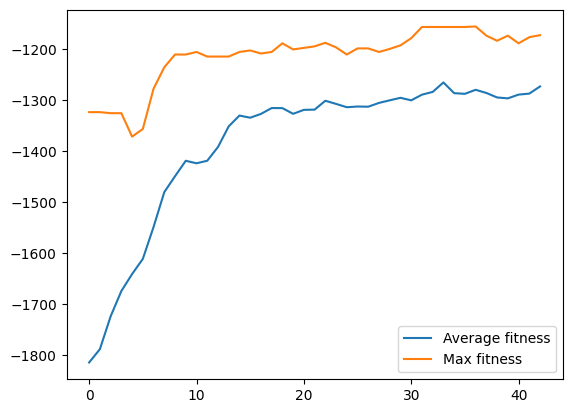

In [58]:
ea_x.plot_fitness()

best_solution_x = ea_x.get_best_solution()

plot_atoms(best_solution_x, atom_species_by_index, atom_species_by_symbol)
plot_solution_with_walls((wall_left, wall_right), best_solution_x, atom_species_by_index, atom_species_by_symbol)
plot_neighbourhood_penalties(np.concat([wall_left, wall_right, best_solution_x]), atom_species_by_index, atom_species_by_symbol, cluster_size, cluster_size, cluster_size)
plot_distances_penalties(np.concat([wall_left, wall_right, best_solution_x]), atom_species_by_index, atom_species_by_symbol)

####  Y-axis

In [85]:
wall_down, wall_up = get_positioned_walls_y(best_solution_x, er_cluster, cluster_size, wall_thickness, solution_thickness)
wall_down, wall_up = replace_cations_with_Si([wall_down, wall_up], atom_species_by_symbol)

In [86]:
initial_population = get_n_random_solutions_without_Er(supercell, 
                                                        cell_size, 
                                                        atom_species_by_symbol, 
                                                        cluster_size, 
                                                        solution_thickness, 
                                                        axis=1, 
                                                        n=population_size)

initial_population = replace_cations_with_Si(initial_population, atom_species_by_symbol)

In [87]:
mutation_type = lambda offspring: random_mutation(mutation_probabilities, offspring, cluster_size, solution_thickness, atom_species_by_symbol, axis=1)

In [88]:
crossover = lambda parents: crossover_fenotypes(parents, cluster_size, solution_thickness, axis=1)

In [89]:
fitness_function = lambda solution: fitness_y(wall_down, wall_up, solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha, beta, gamma)

In [90]:
ea_y = EvolutionaryAlgorithm(initial_population, mutation_type, crossover, selection_proportional, fitness_function)

In [91]:
new_population = ea_y.evolve(n_parents_per_child, n_children, n_elites, max_num_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value)

Generation 0 avg fitness: -3890.886033368257 best fitness: -3301.685622471774
Generation 15 avg fitness: -3028.867006601634 best fitness: -2782.6979758192556
Generation 30 avg fitness: -2895.521760194376 best fitness: -2694.4203850637273
Generation 45 avg fitness: -2688.7612591615016 best fitness: -2490.591295815377
Generation 60 avg fitness: -2551.5858647784703 best fitness: -2390.590871467342
Generation 75 avg fitness: -2484.3227603397277 best fitness: -2331.839784063225
Reached stagnation
Evolution ran for  87 generations, reached best fitness of  -2268.9499583124366


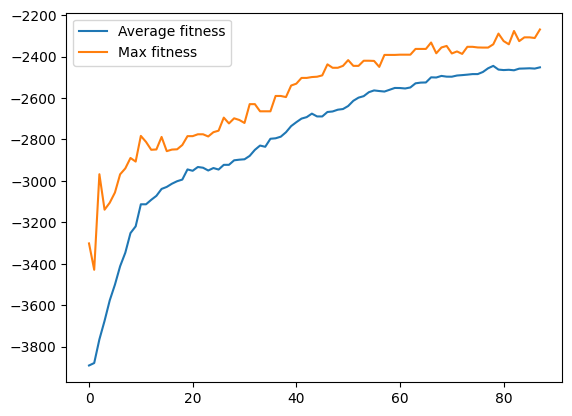

In [92]:
ea_y.plot_fitness()
best_solution_y = ea_y.get_best_solution()

plot_atoms(best_solution_y, atom_species_by_index)
plot_solution_with_walls((wall_down, wall_up), best_solution_y, atom_species_by_index)

####  Z-axis

In [93]:
wall_front, wall_back = get_positioned_walls_z(best_solution_x, best_solution_y, er_cluster, cluster_size, wall_thickness, solution_thickness)
wall_front, wall_back = replace_cations_with_Si([wall_front, wall_back], atom_species_by_symbol)

In [94]:
initial_population = get_n_random_solutions_without_Er(supercell, 
                                                        cell_size, 
                                                        atom_species_by_symbol, 
                                                        cluster_size, 
                                                        solution_thickness, 
                                                        axis=2, 
                                                        n=population_size)

initial_population = replace_cations_with_Si(initial_population, atom_species_by_symbol)

In [95]:
mutation_type = lambda offspring: random_mutation(mutation_probabilities, offspring, cluster_size, solution_thickness, atom_species_by_symbol, axis=2)

In [96]:
crossover = lambda parents: crossover_fenotypes(parents, cluster_size, solution_thickness, axis=2)

In [97]:
fitness_function = lambda solution: fitness_z(wall_front, wall_back, solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha, beta, gamma)

In [98]:
ea_z = EvolutionaryAlgorithm(initial_population, mutation_type, crossover, selection_proportional, fitness_function)

In [99]:
new_population = ea_z.evolve(n_parents_per_child, n_children, n_elites, max_num_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value)

Generation 0 avg fitness: -4864.062567775644 best fitness: -4053.452534567585
Generation 15 avg fitness: -4175.410629039994 best fitness: -3925.984234251252
Generation 30 avg fitness: -3861.8955811778314 best fitness: -3674.630647779744
Generation 45 avg fitness: -3678.880580934246 best fitness: -3515.3300363550925
Generation 60 avg fitness: -3520.798980770777 best fitness: -3331.6964518914547
Generation 75 avg fitness: -3373.637072314719 best fitness: -3224.206848896968
Generation 90 avg fitness: -3258.28998996103 best fitness: -3123.7189324425008
Generation 105 avg fitness: -3082.450485014446 best fitness: -2929.881549444838
Reached stagnation
Evolution ran for  120 generations, reached best fitness of  -2825.5187547750766


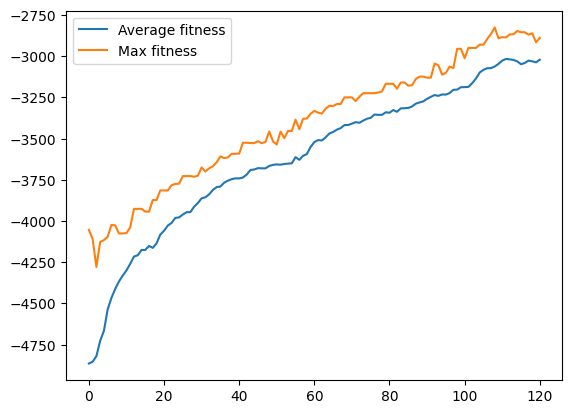

In [104]:
ea_z.plot_fitness()
best_solution_z = ea_z.get_best_solution()

plot_atoms(best_solution_z, atom_species_by_index)
plot_solution_with_walls((wall_front, wall_back), best_solution_z, atom_species_by_index)

In [103]:
plot_atoms(wall_back, atom_species_by_index)

#### Export results

In [53]:
export_to_xcrysden(er_cluster, best_solution_x, best_solution_y, best_solution_z, cluster_size, solution_thickness, atom_species_by_index, 'data/sol.in')

In [54]:
export_to_xcrysden(er_cluster, best_solution_x, None, None, cluster_size, solution_thickness, atom_species_by_index, 'data/sol_x.in')

#### Fitness analysis

In [55]:
fitness_x(wall_left, wall_right, best_solution_x, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha, beta, gamma)

np.float64(-891.2421155659964)

In [56]:
penalty_density(np.concat([wall_left, wall_right, best_solution_x]), 2 * wall_thickness + solution_thickness, cluster_size, cluster_size, atom_species_by_symbol)

0.15736659129507888

In [57]:
penalty_distances(np.concat([wall_left, wall_right, best_solution_x]), atom_species_by_symbol)

np.float64(23.0)

In [61]:
penalty_angles(np.concat([wall_left, wall_right, best_solution_x]), atom_species_by_symbol)

np.float64(0.0)